# Analysis ARPACK MAC results

Get occupied and virtual frontier MOs and check if they came from the same structures.

In [19]:
%matplotlib widget

from os import path
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from qcnico.coords_io import read_xsf
from remove_dangling_carbons import remove_dangling_carbons


datadir = path.expanduser("~/Desktop/simulation_outputs/percolation/40x40")
posdir = path.join(datadir, "structures")
edir = path.join(datadir, 'eARPACK')
Mdir = path.join(datadir,'MOs_ARPACK')

edir_occ = path.join(edir, 'occupied')
edir_vir = path.join(edir, 'virtual')

Mdir_occ = path.join(Mdir, 'occupied')
Mdir_vir = path.join(Mdir, 'virtual')


occ_lbls = np.sort(list(map(int, [f.split('-')[1].split('.')[0] for f in glob(Mdir_occ+'/*npy')])))
vir_lbls = np.sort(list(map(int, [f.split('-')[1].split('.')[0] for f in glob(Mdir_vir+'/*npy')])))

print(occ_lbls.shape)
print(vir_lbls.shape)



# Only work with vir_lbls since not all virtual runs finished, makes it easier to compare

e_arpack_occ = [np.load(edir_occ+f'/eARPACK_bigMAC-{nn}.npy') for nn in vir_lbls] 
e_arpack_vir = [np.load(edir_vir+f'/eARPACK_bigMAC-{nn}.npy') for nn in vir_lbls]


def mos_arpack(Mdir,lbls):
    for nn in lbls:
        yield np.load(Mdir+f'/MOs_ARPACK_bigMAC-{nn}.npy')


def gen_pos(posdir, lbls, rCC):
    for nn in lbls:
        yield remove_dangling_carbons(read_xsf(path.join(posdir,f"bigMAC-{nn}_relaxed.xsf"))[0], rCC)




(300,)
(285,)


## Check 2: General appearance and localisation properties of ARPACK MOs on large graphene ribbons

## Check 3: General appearance and localisation properties of ARPACK MOs on large graphene ribbons

Make sure that $E_{HOMO} < E_{LUMO}$ for all MACs.

In [22]:
nlbls = vir_lbls.shape[0]
bandgaps = np.zeros(nlbls)
for k, eoccs, evirts in zip(range(nlbls),e_arpack_occ, e_arpack_vir):
    eHOMO = np.max(eoccs)
    eLUMO = np.min(evirts)
    bandgaps[k] = eLUMO - eHOMO


print('Number of problematic structures = ', (bandgaps < 0).sum())



Number of problematic structures =  182


Check spacing between adjacent energies for each structure

In [24]:
occ_diffdata = np.zeros((nlbls,5))
vir_diffdata = np.zeros((nlbls,5))
for k in range(nlbls):
    eoccs = np.sort(e_arpack_occ[k])
    evirts = np.sort(e_arpack_vir[k])
    
    diffs_occ = np.diff(eoccs)
    diffs_virt = np.diff(evirts)

    occ_diffdata[k, 0] = np.mean(diffs_occ) 
    vir_diffdata[k, 0] = np.mean(diffs_virt)

    iocc = np.argsort(diffs_occ) 
    ivirt = np.argsort(diffs_virt) 

    occ_diffdata[k,1] = diffs_occ[iocc[-1]] #max inter-level spacing
    vir_diffdata[k,1] = diffs_virt[ivirt[-1]] #max inter-level spacing
    occ_diffdata[k,2] = diffs_occ[iocc[0]] #min inter-level spacing
    vir_diffdata[k,2] = diffs_virt[ivirt[0]] #min inter-level spacing

    # Relative positions of max/min spacing
    occ_diffdata[k,3] = iocc[-1] / eoccs.shape 
    vir_diffdata[k,3] = ivirt[-1] / evirts.shape
    occ_diffdata[k,4] = iocc[0] / eoccs.shape
    vir_diffdata[k,4] = ivirt[0] / evirts.shape

[plt_utils.histogram] dx = 6.786919965701203e-07
[plt_utils.histogram] dx = 9.368435916432949e-07


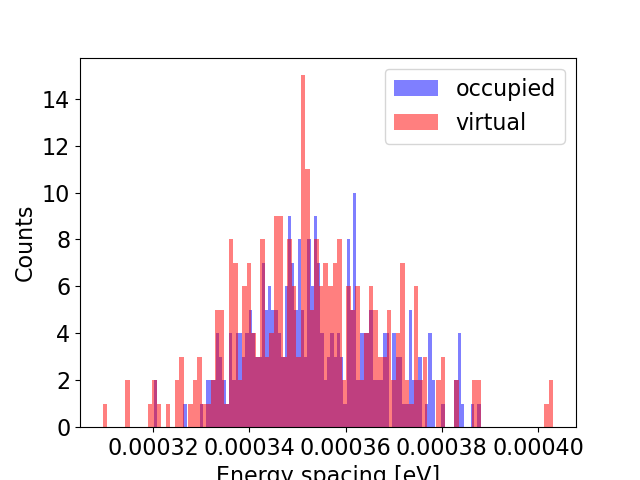

[plt_utils.histogram] dx = 1.287362626609362e-05
[plt_utils.histogram] dx = 1.3687122257915046e-05
[plt_utils.histogram] dx = 7.132315062227668e-07
[plt_utils.histogram] dx = 5.202935433354372e-07


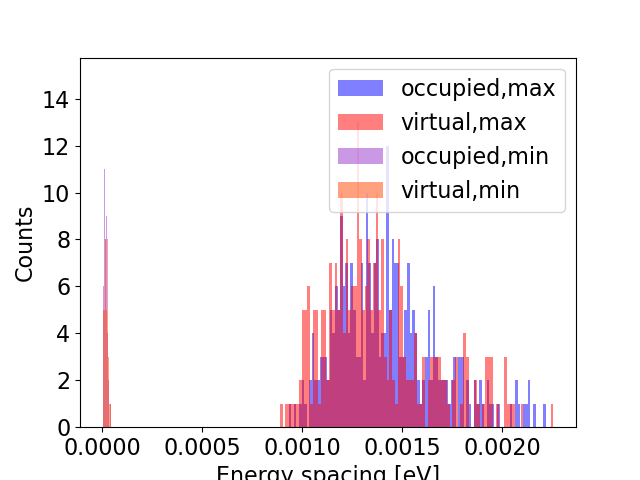

In [27]:
from qcnico.plt_utils import histogram

fig, ax = plt.subplots()

histogram(occ_diffdata[:,0],plt_objs=(fig,ax),plt_kwargs={'color':'b', 'alpha':0.5, 'label':'occupied'},xlabel='Energy spacing [eV]',show=False)
histogram(vir_diffdata[:,0],plt_objs=(fig,ax),plt_kwargs={'color':'r', 'alpha':0.5, 'label':'virtual'},xlabel='Energy spacing [eV]',show=False)
plt.legend()
plt.show()


fig, ax = plt.subplots()

histogram(occ_diffdata[:,1],plt_objs=(fig,ax),plt_kwargs={'color':'b', 'alpha':0.5, 'label':'occupied,max'},xlabel='Energy spacing [eV]',show=False)
histogram(vir_diffdata[:,1],plt_objs=(fig,ax),plt_kwargs={'color':'r', 'alpha':0.5, 'label':'virtual,max'},xlabel='Energy spacing [eV]',show=False)


histogram(occ_diffdata[:,2],plt_objs=(fig,ax),plt_kwargs={'color':'darkorchid', 'alpha':0.5, 'label':'occupied,min'},xlabel='Energy spacing [eV]',show=False)
histogram(vir_diffdata[:,2],plt_objs=(fig,ax),plt_kwargs={'color':'orangered', 'alpha':0.5, 'label':'virtual,min'},xlabel='Energy spacing [eV]',show=False)
plt.legend()
plt.show()

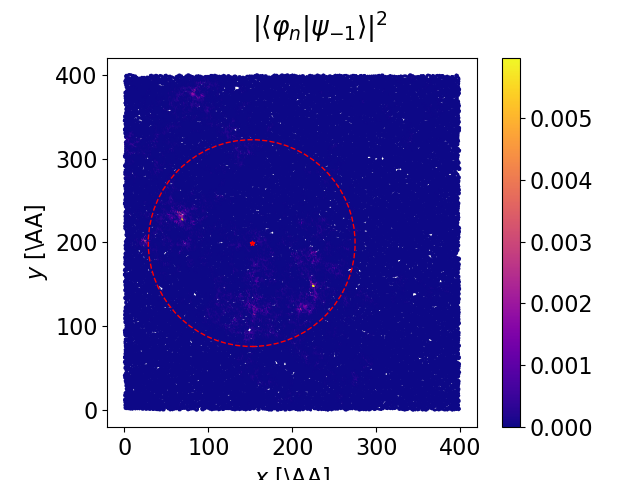

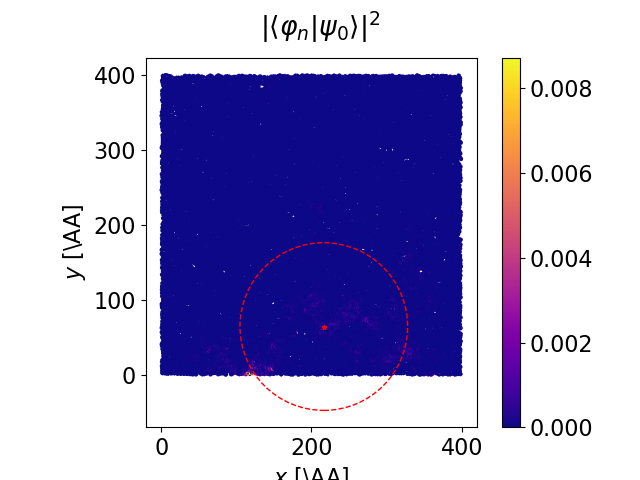

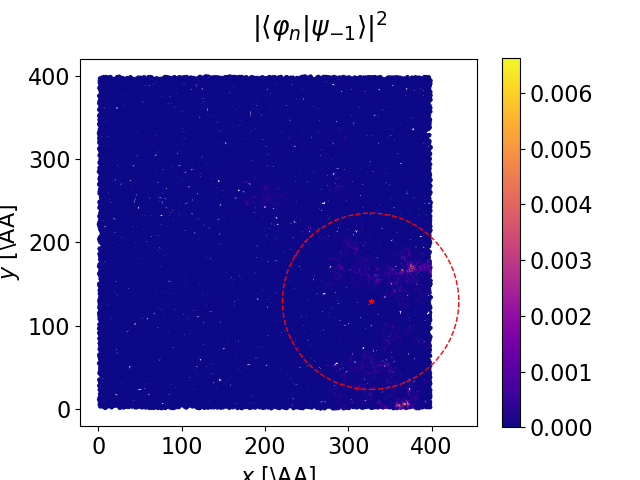

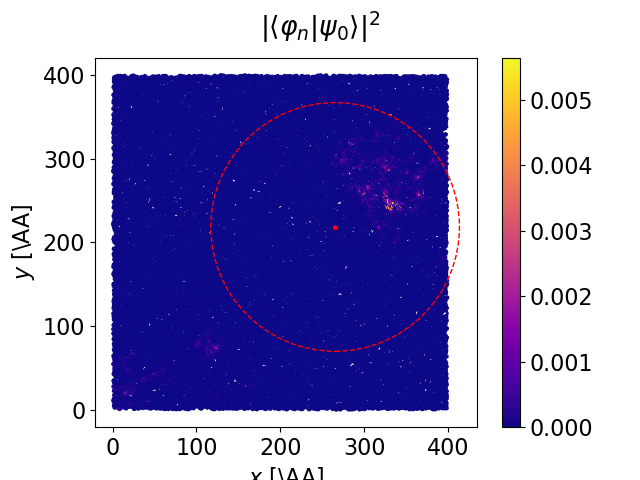

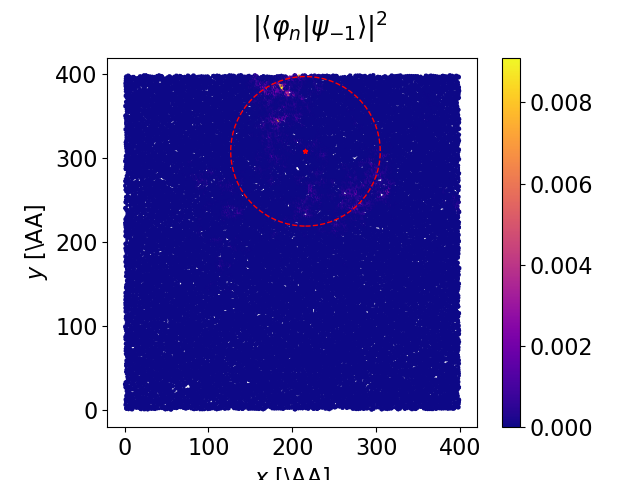

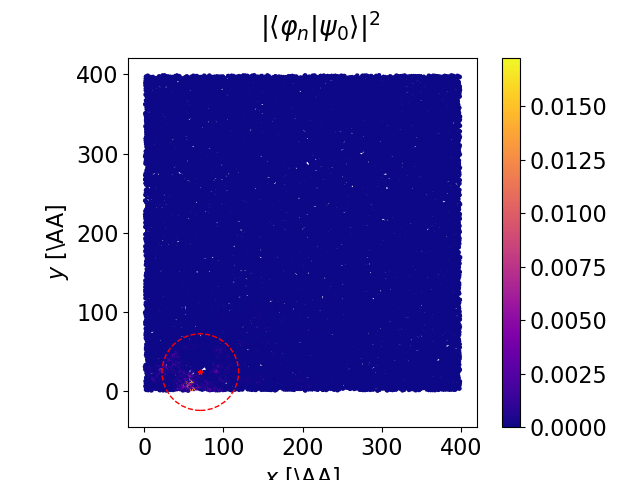

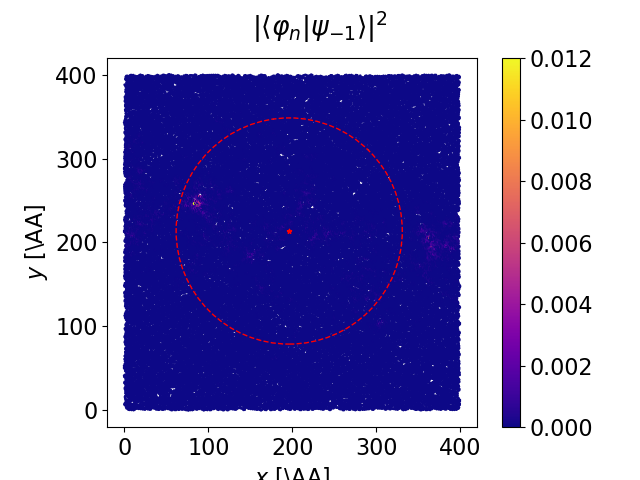

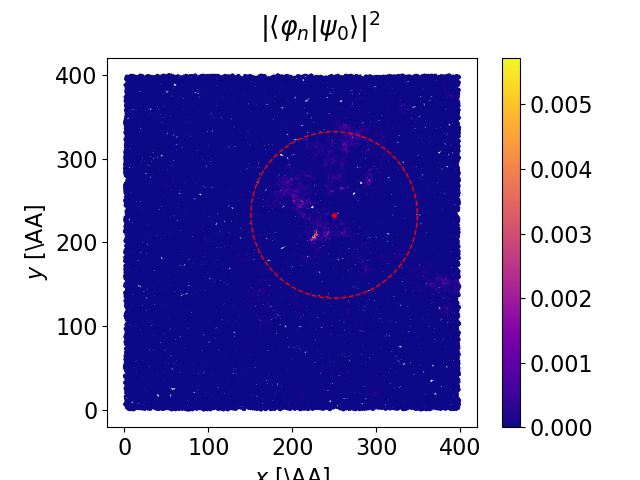

In [23]:
from qcnico.qcplots import plot_MO

eps = 1e-14
sample_inds = vir_lbls[(bandgaps < eps).nonzero()[0][:4]]
rCC = 1.8

for pos, Mocc, Mvir in zip(gen_pos(posdir, sample_inds,rCC),mos_arpack(Mdir_occ,sample_inds), mos_arpack(Mdir_vir,sample_inds)):
    plot_MO(pos,Mocc,-1,dotsize=1.0,show_COM=True,show_rgyr=True,show=True,usetex=False)
    plot_MO(pos,Mvir,0,dotsize=1.0,show_COM=True,show_rgyr=True,show=True,usetex=False)


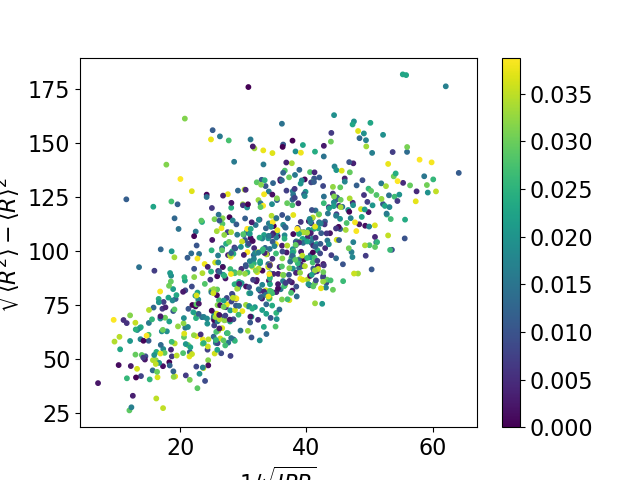

In [5]:

from qcnico.qchemMAC import inverse_participation_ratios, MO_rgyr
from qcnico.qcplots import plot_loc_discrep

fig, ax = plt.subplots()

ns = len(ee)

for k, e, M, pos in zip(range(ns), ee, MM, posarrs):
    e -= e[0]
    iprs = inverse_participation_ratios(M)
    rgyrs = MO_rgyr(pos,M)
    if k == 0:
        plot_loc_discrep(iprs, rgyrs, e, usetex=False, show=False,plt_objs=(fig,ax),show_cbar=True)
    else:
        plot_loc_discrep(iprs, rgyrs, e, usetex=False, show=False,plt_objs=(fig,ax),show_cbar=False)

plt.show()


In [29]:
np.save('vir_lbls.npy', vir_lbls)
natoms = np.zeros(nlbls,dtype='int')
for k, pos in enumerate(gen_pos(posdir, vir_lbls,rCC)):
    natoms[k] = pos.shape[0]

np.save('natoms.npy', natoms)